# Loading Data/Libraries

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("SPX_database_2010.xlsx")
df_total_ret = pd.read_excel("SPX_database_2010.xlsx", sheet_name="total_ret")
df_price = pd.read_excel("SPX_database_2010.xlsx", sheet_name="prices")


In [4]:
import matplotlib.pyplot as plt

# Choosing 30 random companies that existed from 2015-2024

In [8]:
# Convert Dates column to datetime
df_total_ret["Dates"] = pd.to_datetime(df_total_ret["Dates"])
df_price["Dates"] = pd.to_datetime(df_price["Dates"])

# Filter data for 2015-2024
mask = (df_total_ret["Dates"] >= "2015-01-01") & (df_total_ret["Dates"] <= "2024-12-31")
df_filtered = df_total_ret.loc[mask]

# Drop the Dates column to focus only on companies
df_companies = df_filtered.drop(columns=["Dates"])

# Keep only companies with NO NaN in that period
valid_companies = df_companies.columns[df_companies.notna().all()]

# Randomly choose 30 companies
np.random.seed(20)  
selected_companies = np.random.choice(valid_companies, size=30, replace=False)

print("Selected companies:")
print(selected_companies)


Selected companies:
['BG UN Equity' 'NOW UN Equity' 'RTX UN Equity' 'MKTX UW Equity.1'
 'FAST UW Equity' 'CME UW Equity' 'CBRE UN Equity' 'RVTY UN Equity'
 'MPC UN Equity' 'BX UN Equity' 'BRO UN Equity.1' 'FDS UN Equity'
 'ZBRA UW Equity' 'LOW UN Equity' 'EMR UN Equity.1' 'NFLX UW Equity'
 'CFG UN Equity' 'BK UN Equity' 'STZ UN Equity.1' 'WST UN Equity.1'
 'ADBE UW Equity.1' 'HAL UN Equity' 'JBL UN Equity' 'XOM UN Equity'
 'FTNT UW Equity.1' 'DLR UN Equity.1' 'DIS UN Equity.1' 'DVA UN Equity.1'
 'QCOM UW Equity.1' 'CPT UN Equity.1']


# Collect daily returns for selected companies and EW & VW portfolios


In [9]:
# --- Step 1: Filter only the 30 selected companies (from earlier step) ---
df_prices_selected = df_price[["Dates"] + list(selected_companies)]

# --- Step 2: Keep only 2015–2024 ---
mask = (df_prices_selected["Dates"] >= "2015-01-01") & (df_prices_selected["Dates"] <= "2024-12-31")
df_prices_filtered = df_prices_selected.loc[mask].set_index("Dates")

# --- Step 3: Compute daily log returns ---
df_returns = np.log(df_prices_filtered / df_prices_filtered.shift(1)).dropna()

# --- Step 4: Equally weighted portfolio return ---
df_returns["Equal_Weighted_Portfolio"] = df_returns.mean(axis=1)

# --- Final check ---
print(df_returns.head())

            BG UN Equity  NOW UN Equity  RTX UN Equity  MKTX UW Equity.1  \
Dates                                                                      
2015-01-02      0.002746      -0.006951       0.000339         -0.019147   
2015-01-05     -0.020503      -0.003419      -0.016824         -0.019521   
2015-01-06     -0.009450      -0.012287      -0.014250         -0.019466   
2015-01-07      0.005186       0.011393       0.010797          0.008975   
2015-01-08      0.018163       0.026476       0.016882          0.049020   

            FAST UW Equity  CME UW Equity  CBRE UN Equity  RVTY UN Equity  \
Dates                                                                       
2015-01-02       -0.003370      -0.005770        0.012188        0.008199   
2015-01-05       -0.017339       0.005657       -0.021870       -0.023871   
2015-01-06       -0.017217      -0.015405       -0.007695       -0.009101   
2015-01-07       -0.006573       0.011561        0.010344        0.006076   
2015-

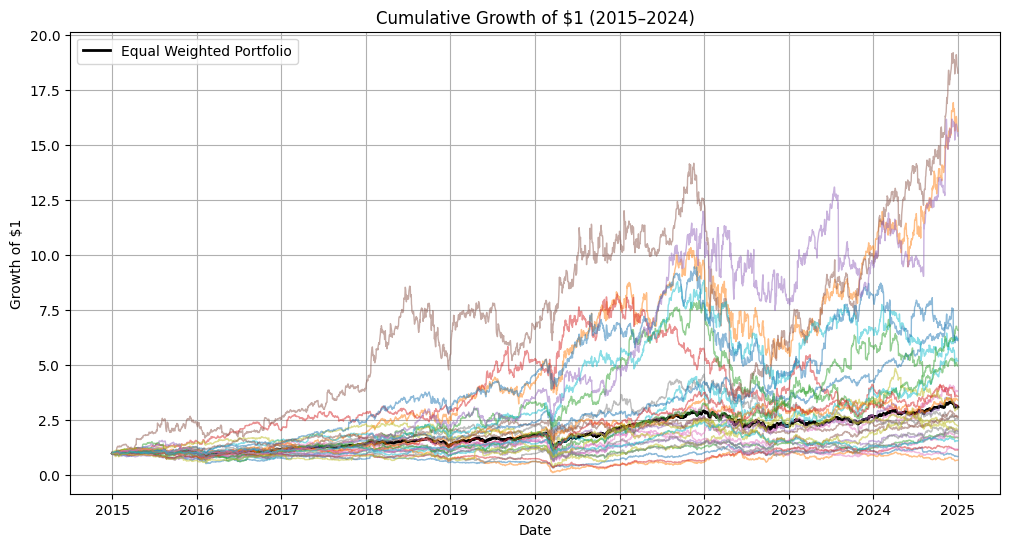

In [10]:
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 6: Plot cumulative growth of $1 ---
plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")

# Optional: plot individual companies (light lines)
for col in selected_companies:
    plt.plot(df_cum_returns.index, df_cum_returns[col], alpha=0.5, linewidth=1)

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

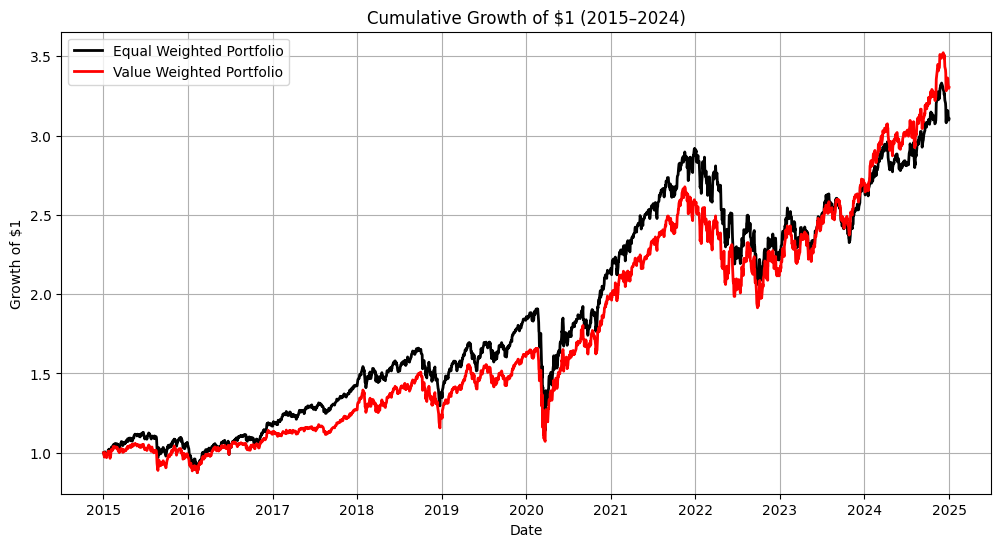

In [11]:
# Load market cap sheet
df_mktcap = pd.read_excel("SPX_database_2010.xlsx", sheet_name="mkt_cap")
df_mktcap["Dates"] = pd.to_datetime(df_mktcap["Dates"])

# Keep only Dates + selected companies
df_mktcap_selected = df_mktcap[["Dates"] + list(selected_companies)]

# Filter to 2015–2024
mask = (df_mktcap_selected["Dates"] >= "2015-01-01") & (df_mktcap_selected["Dates"] <= "2024-12-31")
df_mktcap_filtered = df_mktcap_selected.loc[mask].set_index("Dates")

# Align with returns dataframe (important!)
df_mktcap_filtered = df_mktcap_filtered.loc[df_returns.index]

# --- Step 1: Compute weights (row-wise normalization) ---
weights = df_mktcap_filtered.div(df_mktcap_filtered.sum(axis=1), axis=0)

# --- Step 2: Value-weighted portfolio return ---
# Multiply each stock's return by its weight, then sum across columns
vw_returns = (df_returns[selected_companies] * weights).sum(axis=1)

# Add to dataframe
df_returns["Value_Weighted_Portfolio"] = vw_returns

# --- Step 3: Compute cumulative returns (growth of $1) ---
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 4: Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")
plt.plot(df_cum_returns.index, df_cum_returns["Value_Weighted_Portfolio"], label="Value Weighted Portfolio", linewidth=2, color="red")

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()
